<a href="https://colab.research.google.com/github/tuanlamdao/datascience/blob/master/9_More_Regression_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
cd 'drive/My Drive/Colab Notebooks'

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks'
/content/drive/My Drive/Colab Notebooks


In [3]:
from tuanlam import *
diabetes = datasets.load_diabetes()
d_tts = skms.train_test_split(diabetes.data, diabetes.target, test_size=.25, random_state=42)
(diabetes_train_ftrs, diabetes_test_ftrs, diabetes_train_tgt, diabetes_test_tgt) = d_tts

##### Performing regularized regression

In [4]:
models = [linear_model.Lasso(), linear_model.Ridge()]
for model in models:
    model.fit(diabetes_train_ftrs, diabetes_train_tgt)
    train_preds = model.predict(diabetes_train_ftrs)
    test_preds = model.predict(diabetes_test_ftrs)
    print(get_model_name(model),
         "\n Train MSE:", metrics.mean_squared_error(diabetes_train_tgt, train_preds),
         "\n Test MSE:", metrics.mean_squared_error(diabetes_test_tgt, test_preds))

Lasso 
 Train MSE: 3947.899897977697 
 Test MSE: 3433.1524588051197
Ridge 
 Train MSE: 3461.739515097773 
 Test MSE: 3105.468750907886


##### Comparison of regressors-take three

In [12]:

student_df = pd.read_csv('portugese_student_numeric.csv')
student_ftrs = student_df[student_df.columns[:-1]]
student_tgt = student_df['G3']
student_tts = skms.train_test_split(student_ftrs, student_tgt)
(student_train_ftrs, student_test_ftrs, student_train_tgt, student_test_tgt) = student_tts
old_school = [linear_model.LinearRegression(), neighbors.KNeighborsRegressor(n_neighbors=3),neighbors.KNeighborsRegressor(n_neighbors=10)]
pernalized_lr = [linear_model.Lasso(), linear_model.Ridge()]
svrs = [svm.SVR(), svm.NuSVR()]
dtrees = [tree.DecisionTreeRegressor(max_depth=md) for md in [1,3,5,10]]
reg_models = old_school + pernalized_lr + svrs + dtrees


In [13]:
def rms_error(actual, predicted):
    'Root-mean-squared-error function'
    #lesser values are better ( a<b means a is better)
    mse = metrics.mean_squared_error(actual, predicted)
    return np.sqrt(mse)
rms_scorer = metrics.make_scorer(rms_error)

In [14]:
scaler = skpre.StandardScaler()
scores = {}
for model in reg_models:
    pipe = pipeline.make_pipeline(scaler, model)
    preds = skms.cross_val_predict(pipe, student_ftrs, student_tgt, cv=10)
    key = (get_model_name(model) + str(model.get_params().get('max_depth',"")) + str(model.get_params().get('n_neighbors',"")))
    scores[key] = rms_error(student_tgt, preds)
df = pd.DataFrame.from_dict(scores, orient='index').sort_values(0)
df.columns=['RMSE']
display(df)

NameError: ignored

,RMSE
DecisionTreeRegressor1,4.3192
Ridge,4.3646
LinearRegression,4.3653
NuSVR,4.3896
SVR,4.4062
DecisionTreeRegressor3,4.4298
Lasso,4.4375
KNeighborsRegressor10,4.4873
DecisionTreeRegressor5,4.8127
KNeighborsRegressor3,4.8915


For the top 4 models, let's see some details about performance on a fold-by-fold basis.

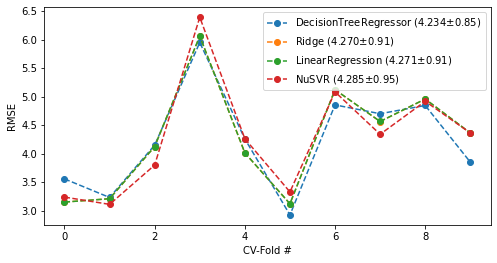

In [15]:
better_models = [tree.DecisionTreeRegressor(max_depth=1), linear_model.Ridge(), linear_model.LinearRegression(),svm.NuSVR()]
fig, ax = plt.subplots(1,1,figsize=(8,4))
for model in better_models:
    pipe = pipeline.make_pipeline(scaler, model)
    cv_results = skms.cross_val_score(pipe, student_ftrs, student_tgt, scoring=rms_scorer, cv=10)
    my_lbl = "{:s} ({:5.3f}$\pm${:.2f})".format(get_model_name(model), cv_results.mean(), cv_results.std())
    ax.plot(cv_results, 'o--', label=my_lbl)
    ax.set_xlabel('CV-Fold #')
    ax.set_ylabel("RMSE")
    ax.legend()